## Dataset Link:
- https://www.kaggle.com/c/data-science-bowl-2018/data
- NOTE: instructions for Kaggle competition were not followed, this is code was done during my Community College Internship (CCI) at Lawrence Berkeley National Lab (LBNL) as a prerequisite to my research. This code displays similar work done with similar processes and the same model. My code for the research done during the internship could not be shared as it contained confidential data. 

### Google Colab Setup:

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

# !mkdir test
# %cd test
# !unzip "/content/drive/My Drive/stage1_test.zip"

# %cd ..
# !mkdir train
# %cd train
# !unzip "/content/drive/My Drive/stage1_train.zip"
# %cd ..

### Local Setup:

In [6]:
!mkdir test
%cd test
!unzip "../stage1_test.zip"

%cd ..
!mkdir train
%cd train
!unzip "../stage1_train.zip"
%cd ..

In [7]:
# check to see that train and test folder has been created:
!ls

README.md               stage1_test.zip         test
cell_segmentation.ipynb stage1_train.zip        train


In [8]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import skimage.measure

## Setting up the Data:
- cleaning the data
- splitting into train and test

In [9]:
# define common variables:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'train/'
TEST_PATH = 'test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [10]:
# define X train and Y train tensors:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [11]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')

100%|██████████| 670/670 [00:03<00:00, 171.92it/s]


In [12]:
# Data Cleaning:
start = timer()

print('\nResizing training images and masks\n')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  # Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

  0%|          | 2/670 [00:00<01:05, 10.25it/s]


Resizing training images and masks



100%|██████████| 670/670 [06:10<00:00,  1.81it/s]


In [13]:
# test images:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [14]:
# Data Cleaning:
sizes_test = []
print('\nResizing test images\n') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('\nDone!\n')
end = timer()
print("\nTime taken load data: ", end - start, "seconds\n") 

  5%|▍         | 3/65 [00:00<00:02, 26.35it/s]


Resizing test images



100%|██████████| 65/65 [00:01<00:00, 38.00it/s]


Done!


Time taken load data:  371.986062341 seconds



In [15]:
# check tensor shapes:
X_train = tf.random.shuffle(X_train, seed=101).numpy()
Y_train = tf.random.shuffle(Y_train, seed=101).numpy()
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(670, 128, 128, 3)
(670, 128, 128, 1)
(65, 128, 128, 3)


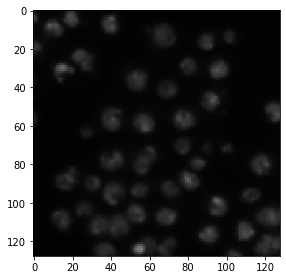

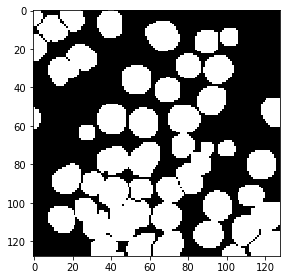

In [16]:
# display random x_train and y_train image:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

## Model

In [17]:
# FCN8 Model

def fcn8(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, kernel_size):
  inputs = tf.keras.layers.Input(shape=(None, None, IMG_CHANNELS))
  s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # converting to float so keras can handle it better

  # Downsampling
  c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(s)
  # c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

  c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
  # c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

  c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
  c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
  # c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

  c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
  c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
  # c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

  c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p4)
  c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
  # c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
  p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

  c6 = tf.keras.layers.Conv2D(512, (7, 7), activation='relu', padding='same')(p5)
  # c6 = tf.keras.layers.Dropout(0.5)(c6)
  c6 = tf.keras.layers.Conv2D(512, (1, 1), activation='relu', padding='same')(c6)
  c6 = tf.keras.layers.Dropout(0.5)(c6)

  # Upsampling
  # deconv 1
  u1 = tf.keras.layers.Conv2DTranspose(1, kernel_size=kernel_size, strides=(2, 2), padding='same')(c6)

  p4_n = tf.keras.layers.Conv2D(1, (2, 2), activation='relu', padding='same')(p4)

  # deconv 2
  u2 = tf.keras.layers.Add()([u1, p4_n])
  u2 = tf.keras.layers.Conv2DTranspose(1, kernel_size=kernel_size, strides=(2, 2), padding='same')(u2)

  p3_n = tf.keras.layers.Conv2D(1, (2, 2), activation='relu', padding='same')(p3)

  
  #deconv 3
  u3 = tf.keras.layers.Add()([u2, p3_n])

  # multiply top kernel size by 4:
  outputs = tf.keras.layers.Conv2DTranspose(1, kernel_size=kernel_size*4, strides=(8, 8), padding='same', activation='sigmoid')(u3)

  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()

  return model


In [18]:
kernel_size = 8

model = fcn8(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, kernel_size)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 8 224         lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 8 584         conv2d[0][0]                     
______________________________________________________________________________________________

In [19]:
#Modelcheckpoint
# checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei_3.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
        # tf.keras.callbacks.EarlyStopping(patience=5, monitor='accuracy'),
        # tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1)
]

start = timer()

results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=32, epochs=200, callbacks=callbacks)
# results = model.fit(X_train[:100], Y_train[:100], epochs=250, callbacks=callbacks)

end = timer()
print("\nTime taken for Model to Run: ", end - start, "seconds\n") 

Train on 536 samples, validate on 134 samples
Epoch 1/200
536/536 [==============================] - 13s 24ms/sample - loss: 0.6681 - accuracy: 0.7271 - val_loss: 0.6015 - val_accuracy: 0.7380
Epoch 2/200
536/536 [==============================] - 11s 21ms/sample - loss: 0.5625 - accuracy: 0.7781 - val_loss: 0.5364 - val_accuracy: 0.7959
Epoch 3/200
536/536 [==============================] - 11s 20ms/sample - loss: 0.5382 - accuracy: 0.7986 - val_loss: 0.5274 - val_accuracy: 0.7982
Epoch 4/200
536/536 [==============================] - 10s 19ms/sample - loss: 0.5134 - accuracy: 0.7995 - val_loss: 0.4975 - val_accuracy: 0.7986
Epoch 5/200
536/536 [==============================] - 11s 20ms/sample - loss: 0.4913 - accuracy: 0.7997 - val_loss: 0.4864 - val_accuracy: 0.7986
Epoch 6/200
536/536 [==============================] - 11s 21ms/sample - loss: 0.4665 - accuracy: 0.7995 - val_loss: 0.4552 - val_accuracy: 0.7985
Epoch 7/200
536/536 [==============================] - 11s 20ms/sample -

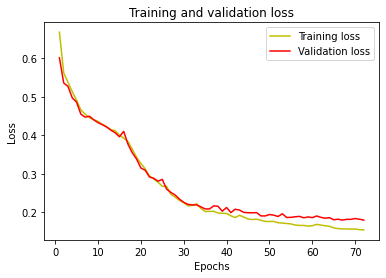

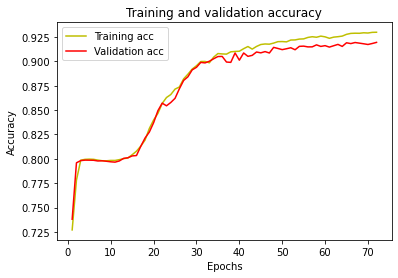

In [20]:
#plot the training and validation accuracy and loss at each epoch
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Predictions with Trained Model

In [21]:
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

65/65 [==============================] - 0s 6ms/sample


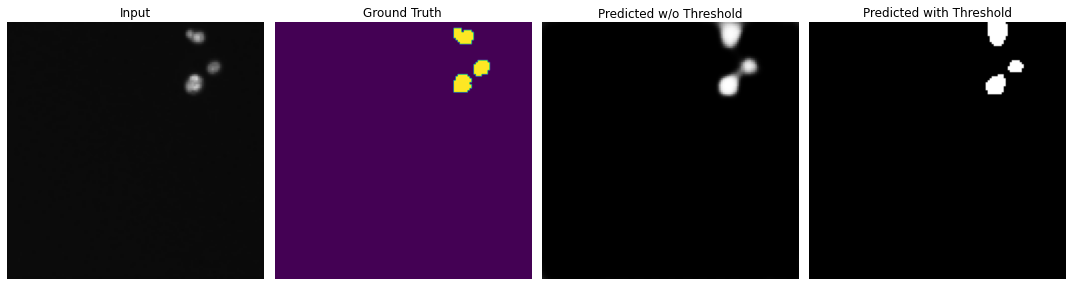

In [30]:
# Perform predictions on some training samples
ix = random.randint(0, len(preds_train_t))

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,10))

ax[0].set_title("Input")
ax[0].imshow(X_train[ix])

ax[1].set_title("Ground Truth")
ax[1].imshow(np.squeeze(Y_train[ix]))

ax[2].set_title("Predicted w/o Threshold")
ax[2].imshow(np.squeeze(preds_train[ix]), cmap='gray')

ax[3].set_title("Predicted with Threshold")
ax[3].imshow(np.squeeze(preds_train_t[ix]), cmap='gray')

for a in ax:
  a.axis("off")

plt.tight_layout()
plt.show()


## Simple Metrics

In [31]:
# function to calculate Intersection Over Union (IOU) score:
def iou_score(truth, predicted):
    intersection = np.logical_and(truth, predicted)
    union = np.logical_or(truth, predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    
    return iou_score

iou = iou_score(Y_train, preds_train_t)
print("IOU score: ", round(iou, 2))

IOU score:  0.7


In [32]:
# utilize connected component analysis (CCA) to count cells in random (ix) image:
labeled_image = skimage.measure.label(preds_train_t[ix], connectivity=2, return_num=True)

print("mask w/ threshold cell count: ", np.max(labeled_image[0]))

mask w/ threshold cell count:  3


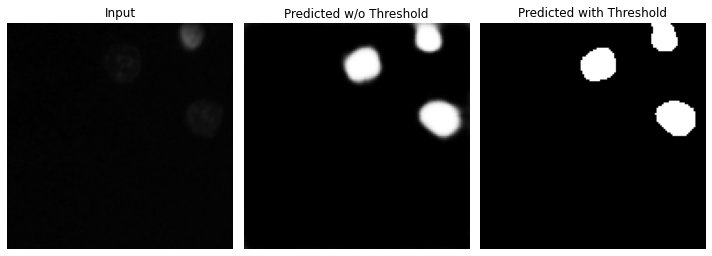

In [33]:
# Perform predictions on some testing samples
ix = random.randint(0, len(preds_test_t))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,10))

ax[0].set_title("Input")
ax[0].imshow(X_test[ix])

ax[1].set_title("Predicted w/o Threshold")
ax[1].imshow(np.squeeze(preds_test[ix]), cmap='gray')

ax[2].set_title("Predicted with Threshold")
ax[2].imshow(np.squeeze(preds_test_t[ix]), cmap='gray')

for a in ax:
  a.axis("off")

plt.tight_layout()
plt.show()


In [26]:
# %load_ext tensorboard
# %tensorboard --logdir logs

In [27]:
# !rm -r logs

In [28]:
# save model
# model.save('fcn_model_92.h5')

# checkpoint_filepath = 'nuclei_model_3.h5'
# model.load_weights(checkpoint_filepath)

In [29]:
# tf.keras.utils.plot_model(
#     model, to_file='model.png', show_shapes=False, show_layer_names=True,
#     rankdir='TB', expand_nested=False, dpi=96
# )